## FFT Approach to Fourier Optics Computations

In [2]:
## general imports
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from time import time
import random as rand

## local imports
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display
display(HTML("<style>.container{width:100% !important;}</style>"))

## scaling FFTs

FFTs aren't fit by default for doing transformations of an optical field by a lens, which can be expressed as a phase mask $exp(-i k \mathbf{\rho_2} \cdot \mathbf{\rho_1}/f)$


Fresnel diffraction:

\begin{equation*}
    A2(\rho_2) = \frac{-i k}{z} e^{i\frac{k}{2 z} \rho_2^2} \mathfrak{F}\big[ A1(\rho_1) e^{i \frac{k}{2 z}\rho_1^2} \big]_{k_{\perp,1}=\frac{k}{z}\rho_2}
\end{equation*}

Transformation by a lens to a distance z2 from the lens, when the object is in the front focal plane:

\begin{equation*}
    A2(\rho_2) = \frac{-i k}{2 \pi f} \mathfrak{F}\big[ A1(\rho_1) e^{ \frac{-i k}{2 f}\rho_1^2(\frac{L_2}{f} - 1)} \big]_{k_{\perp,1}=\frac{k}{f}\rho_2}
\end{equation*}

2D FFT of some array A1:

\begin{equation*}
    A2_{kl} = \sum_{n=0}^{N-1}\sum_{m=0}^{M-1} A1_{nm} \exp \bigg(\frac{-i 2 \pi k n}{N}\bigg) \exp \bigg(\frac{-i 2 \pi l m}{M}\bigg)
\end{equation*}

where in the FT, the exponential in the integrand looks like $exp\big(-i\frac{k}{z}x_1 x_2\big) exp\big(-i\frac{k}{z}y_1 y_2\big) $, $k = 2\pi/ \lambda$. The input field points are separated in real space by $\delta x_1$, and the spacing between field points in the Fourier plane must be proportional to $\delta x_1$. Taking into account that the resolution in the output field must be inversely proportional the number of input pts making up the field, along with the factors in the exponential above, we deduce that the real space separation of points in the Fourier plane is $k z/(\delta x_1 N)$, with the N the number of pts in dimension x. 


## test with circular aperture

In [3]:
## physics and system params
lmbda = 1.064e-6
k = 2*pi/lmbda
f = .1 # 10 cm lens
a = 1e-4
d = 3*a
b = f*3.8317/(a*k)
print(f'b = {b}')

## grid params
w = d # grid half-width
pts = 2001 #1025
x = linspace(-w, w, pts)
y = linspace(-w, w, pts)
x1pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)

b = 0.0006488633711537092


In [4]:
mask = zeros((pts,pts))
for i in range(pts):
    for j in range(pts):
        if rr[i,j] < a:
            mask[i,j] = 1

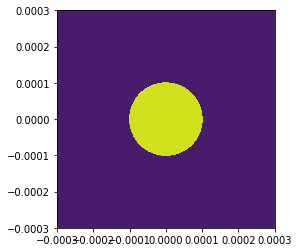

In [5]:
fig, ax = figax()
ax.contourf(x1pts, x1pts, mask)

In [6]:
## compute 1D fft
A1x = ifftshift(fft(mask[midpt, :]))
I1x = conjugate(A1x)*A1x
I1x/= amax(I1x)
I1x = justify(I1x)

'b = 0.0006488633711537092'

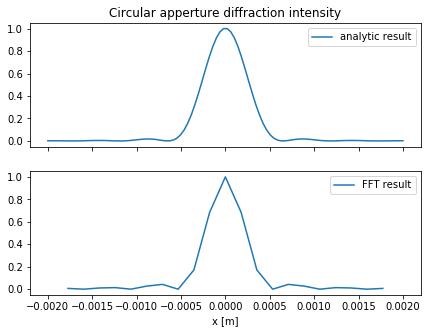

In [7]:
## plot the 1D fft

fig,axes = plt.subplots(2,1, sharey=True, sharex=True, figsize=(7,5))
ax1,ax2 = axes
ax1

# plot the analytic result, up to constant scaling factor
I1_func = lambda x: (j1(a*x*k/f)/x)**2
x2_pts = linspace(-0.002, 0.002, 100)
I1_analytic = I1_func(x2_pts)
I1_analytic /= max(I1_analytic)
ax1.plot(x2_pts, I1_analytic, label='analytic result')
ax1.set_title('Circular apperture diffraction intensity')

start = 990
stop = len(x1pts) - 990
x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f/pts for i in linspace(-pts/2, pts/2, pts)])
ax2.plot(x2pts[start:stop], real(I1x)[start:stop], label='FFT result')
ax2.set_xlabel(r'x [m]')

for ax in axes:
    ax.legend(loc='upper right')

f"b = {b}"

## 4f Imaging with analytic Fourier plane field

In [78]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
a = 1e-4
dx = 4.3*a
dy = dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

## grid params
w = 3*b # grid half-width
pts = 2000 #1025
x = linspace(-w, w, pts)
y = linspace(-w, w, pts)
x1pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)

b=0.005031, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000101


In [60]:
## compute the Fourier plane field with analytic result

def repeat_phase(x1,y1,dx,dy,xnum,ynum,f1,k):
    """
    The sinusoidal factor appearing in the Fourier plane for an input
    field of x (y) periodicity dx (dy)

    x1,y1: spatial coordinate in the Fourier plane
    dx,dy: periodicity in x,y
    f1: focal length of the lens
    """
    return (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
            /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1)))))

field1 = zeros((pts, pts))

q3_phases = empty((midpt, midpt), complex)
q3 = empty((midpt, midpt), complex)
for i in range(midpt):
    for j in range(midpt):
        q3_phases[i,j] = repeat_phase(x1pts[i], x1pts[j], dx, dy, xnum, ynum, f1, k)
        q3[i,j] = A0*a*j1(a*rr[i,j]*k/f1)*q3_phases[i,j]/rr[i,j]
print(f"calculated in {time()-t0} s")

calculated in 1753.4211120605469 s


In [61]:
field1 = from_quadrant3(q3)

(1000, 1000) (2000, 2000)


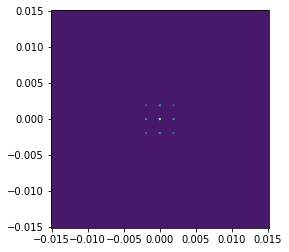

In [62]:
# fig, ax = figax()
# I1_xy = conjugate(field1)*field1
# ax.contourf(x1pts, x1pts, I1_xy)

In [79]:
## make a phase mask for the fft argument -- this propagates the field
prop = lambda z2, f2, rr: exp(-1j*k*rr**2*(z2/f2 - 1)/(2*f)) # = 1 when z2 = f2

In [83]:
## compute the 2D fft
t0 = time()
z2 = f2 - zTalbotx
field2 = fftshift(fft2(ifftshift(field1*prop(z2, f2, rr)))) # might need a nyquist mask?
print(f"calculated in {time()-t0} s")

calculated in 1.134608507156372 s


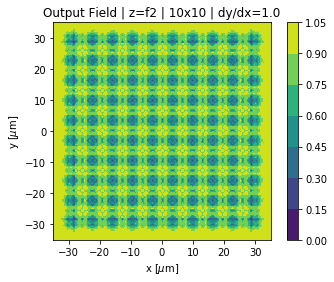

In [84]:
I2_xy = conjugate(field2)*field2
I2_xy = 1 - I2_xy/amax(I2_xy)

x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/pts for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6
fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'y [$\mu$m]')
cbar = ax.contourf(x2pts*scl, x2pts*scl, I2_xy)
fig.colorbar(cbar)
ax.set_title(f'Output Field | z=f2 | {xnum}x{ynum} | dy/dx={dy/dx}')
plt.savefig('bright')

In [85]:
## function to compute the output plane field given 
def intensity2_xy(field1, z2, f2, norm=None):
    """
    Returns:
        int2: intensity in xy plane at z2 from lens f2
        norm: the intensity maximum
    """
    t0 = time()
    field2 = fftshift(fft2(ifftshift(field1))) # might need a nyquist mask?
    print(f"calculated in {time()-t0} s")
    
    I2_xy = conjugate(field2)*field2
    if norm is None:
        norm = amax(I2_xy)
    I2_xy = 1 - I2_xy/amax(I2_xy)
    
    return I2_xy, norm 